# Setup

In [1]:
from graph_tool.all import *

# Why Graph-tool?

+ NetworkX is perfect for prototyping - it's flexible and provides a variety of algorithms and functions
+ Graph-tool complements NetworkX - it makes possible to scale a prototype up (see the [performance comparison results](https://graph-tool.skewed.de/performance))

# Manipulating graphs

## Creating a graph

In [14]:
# by default, new graphs are directed
g = Graph()

# if you want an undirected graphs
ug = Graph(directed=False)

In [15]:
# to force a graph to be undirected
assert ug.is_directed() == False

## Adding vertices and edges linking vertices

In [18]:
# adding vertices one-by-one
v1 = g.add_vertex()
v2 = g.add_vertex()

In [19]:
# adding multiple vertices in a row
vlist = g.add_vertex(2)

In [ ]:
# edges
e = g.add_edge(v1, v2)

In [17]:
# calling edges
print(e.source(), e.target())

0 1


## Iterating over vertices and edges

In [22]:
for v in g.vertices():
    print(v)
    

for e in g.edges():
    print(e)
    


0
1
2
3
4
5
(0, 1)


## Iterating over the neighbors of a vertex

In [24]:
# ptyhon way
for v in g.vertices():
   for e in v.out_edges():
       print(e)
   for w in v.out_neighbors():
       print(w)
    


(0, 1)
1


In [25]:
# numpy way

'''
Following the numpy philosophy, graph_tool also provides an array-based 
interface that avoids loops in Python. This is done with the:

- get_vertices()
- get_edges()
- get_out_edges()
- get_in_edges()
- get_all_edges()
- get_out_neighbors()
- get_in_neighbors()
- get_all_neighbors()
- get_out_degrees()
- get_in_degrees()
- get_total_degrees() methods

All these function return numpy.ndarray instances instead of iterators.
'''

print(g.get_out_degrees(g.get_vertices()))

[1 0 0 0 0 0]


# I/O

In [26]:
# create a graph
g = Graph()

# write data to a compressed, xml
g.save("my_graph.xml.gz")

# load data back
g2 = load_graph("my_graph.xml.gz")

# Drawing a network

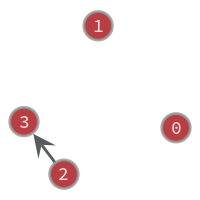

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa2fcccc860, at 0x7fa2c5366908>

In [11]:
# gt has a builtin function
graph_draw(g,
           vertex_text=g.vertex_index,
           vertex_font_size=18,
           output_size=(200, 200),
           #output="two-nodes.png")
          )

# Fully-developed example

The task consists of building a Price network (the one that existed before Barabasi). It is a directed network, with preferential attachment. 

In [29]:
# load libraries
from __future__ import division, absolute_import, print_function
import sys
if sys.version_info < (3,):
    range = xrange
import os
from pylab import *         # for plotting
from numpy.random import *  # for random sampling

In [30]:
# fixing a seed that ensures reproducibility
seed(42)

In [31]:
# empty graph
g = Graph()

In [32]:
# create two containers in which we store vertex- and edge-level property
v_age = g.new_vertex_property("int")
e_age = g.new_edge_property("int")

In [33]:
# network simulation
N = 100000

# We have to start with one vertex
v = g.add_vertex()
v_age[v] = 0

# we will keep a list of the vertices. The number of times a vertex is in this
# list will give the probability of it being selected.
vlist = [v]

# let's now add the new edges and vertices
for i in range(1, N):
    # create our new vertex
    v = g.add_vertex()
    v_age[v] = i

    # we need to sample a new vertex to be the target, based on its in-degree +
    # 1. For that, we simply randomly sample it from vlist.
    i = randint(0, len(vlist))
    target = vlist[i]

    # add edge
    e = g.add_edge(v, target)
    e_age[e] = i

    # put v and target in the list
    vlist.append(target)
    vlist.append(v)

# now we have a graph!

# let's do a random walk on the graph and print the age of the vertices we find,
# just for fun.

v = g.vertex(randint(0, g.num_vertices()))
while True:
    print("vertex:", int(v), "in-degree:", v.in_degree(), "out-degree:",
          v.out_degree(), "age:", v_age[v])

    if v.out_degree() == 0:
        print("Nowhere else to go... We found the main hub!")
        break

    n_list = []
    for w in v.out_neighbors():
        n_list.append(w)
    v = n_list[randint(0, len(n_list))]

# let's save our graph for posterity. We want to save the age properties as
# well... To do this, they must become "internal" properties:

g.vertex_properties["age"] = v_age
g.edge_properties["age"] = e_age

# now we can save it
g.save("price.xml.gz")

vertex: 36063 in-degree: 0 out-degree: 1 age: 36063
vertex: 9075 in-degree: 4 out-degree: 1 age: 9075
vertex: 5967 in-degree: 3 out-degree: 1 age: 5967
vertex: 1113 in-degree: 7 out-degree: 1 age: 1113
vertex: 25 in-degree: 84 out-degree: 1 age: 25
vertex: 10 in-degree: 541 out-degree: 1 age: 10
vertex: 5 in-degree: 140 out-degree: 1 age: 5
vertex: 2 in-degree: 459 out-degree: 1 age: 2
vertex: 1 in-degree: 520 out-degree: 1 age: 1
vertex: 0 in-degree: 210 out-degree: 0 age: 0
Nowhere else to go... We found the main hub!


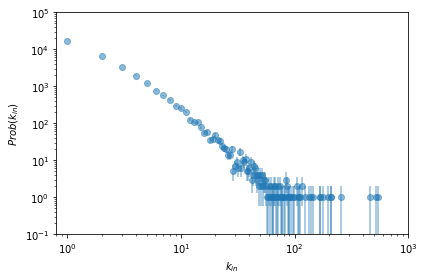

In [37]:
# get node in-degree
in_hist = vertex_hist(g, "in")

# data series
# --+ point estimates
y = in_hist[0]
# --+ confidence interval
err = sqrt(in_hist[0])
err[err >= y] = y[err >= y] - 1e-2

# create figure
figure(figsize=(6,4))

# plot data with Matplotlib errorbar
errorbar(in_hist[1][:-1], in_hist[0],
         fmt="o", alpha=0.5,
         yerr=err,
         label="in")

# axes
gca().set_yscale("log")
gca().set_xscale("log")
gca().set_ylim(1e-1, 1e5)
gca().set_xlim(0.8, 1e3)

# 
subplots_adjust(left=0.2, bottom=0.2)

# labels
xlabel("$k_{in}$")
ylabel("$Prob(k_{in})$")

# save figure
tight_layout()
savefig("price-deg-dist.pdf")
savefig("price-deg-dist.svg")

In [36]:
# drawing the simulated Price network

# load data
g = load_graph("price.xml.gz")

# recall the age of vertices
age = g.vertex_properties["age"]

# create node-level positions
pos = sfdp_layout(g)

# draw the network
graph_draw(g,
           pos,
           output_size=(1000, 1000),
           vertex_color=[1,1,1,0],
           vertex_fill_color=age,
           vertex_size=1,
           edge_pen_width=1.2,
           vcmap=matplotlib.cm.gist_heat_r,
           output="price.png")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fa2ba614cc0, at 0x7fa2ba63e048>